# **Soal 2B Autoencoder**

# **2702265641 - Tiffanny Felita**

**LINK Video** : https://youtu.be/qvNzG6wHSWU

**Autoencoder Image** adalah model neural network unsupervised yang terdiri dari **encoder** untuk meringkas gambar dan **decoder** untuk merekonstruksi kembali gambar asli. Model ini digunakan untuk **denoising**, **reduksi dimensi**, dan **deteksi anomali**, dengan cara meminimalkan perbedaan antara gambar asli dan hasil rekonstruksinya.


# **Import Library**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import zipfile
from skimage.metrics import structural_similarity as ssim
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import imagehash

import dask.bag as db
from dask.diagnostics import ProgressBar

# **Read Data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = '/content/drive/MyDrive/DeepLearning/B_23.zip'
extract_base_path = '/content/dataset/' # Path dasar untuk ekstraksi

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_base_path)

print(f"Isi dari {extract_base_path}: {os.listdir(extract_base_path)}")

Isi dari /content/dataset/: ['B_23']


Untuk membuka dan mengekstrak file ZIP (B_23.zip) dari Google Drive ke folder lokal (/content/dataset/), lalu menampilkan isi folder tersebut setelah ekstraksi.

In [4]:
data_folder = os.path.join(extract_base_path, 'B_23')

image_paths = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
images = []
for img_path in image_paths:
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
images = np.array(images)

print(f"Total gambar yang dimuat: {len(images)}")
if len(images) > 0:
    print(f"Dimensi gambar pertama (contoh): {images[0].shape}")
else:
    print("Tidak ada gambar yang ditemukan. Pastikan path folder sudah benar dan berisi gambar.")

Total gambar yang dimuat: 1074
Dimensi gambar pertama (contoh): (600, 600, 3)


- **Ada 1074 file gambar** yang berhasil dibaca dari dataset.

- Dimensi gambar pertama: **(600, 600, 3)**
Gambar pertama memiliki **ukuran 600 piksel x 600 piksel, dengan 3 channel warna (RGB)**, artinya gambar berwarna.

# ** Bagian a: EDA**

# **EDA Visualisasi Contoh Gambar**

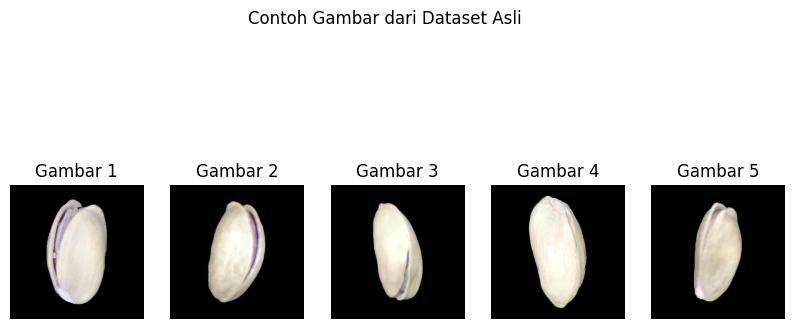

In [15]:
plt.figure(figsize=(10, 5))
for i in range(min(5, len(images))):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Gambar {i+1}")
    plt.axis('off')
plt.suptitle("Contoh Gambar dari Dataset Asli")
plt.show()

**Menampilkan gambar asli saat EDA penting untuk memahami visual data sebelum dilakukan preprocessing. Membantu melihat kualitas gambar, seperti tingkat kecerahan, noise, warna dominan, dan potensi masalah seperti blur sehingga bisa menentukan proses preprocessing yang tepat.**

# **Corrupted Images**

**Cek data rusak dan duplikat penting dilakukan agar model tidak belajar dari data yang tidak valid atau berulang, karena itu bisa menurunkan kualitas pelatihan dan membuat hasil model kurang akurat atau bias. Data yang rusak juga bisa menyebabkan error saat training.**

In [8]:
def check_corrupted_files(directory):
    corrupted = []
    image_files = [f for f in os.listdir(directory) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for filename in image_files:
        img_path = os.path.join(directory, filename)
        try:
            with Image.open(img_path) as img:
                img.verify()  # Verifies image integrity without loading pixels
        except Exception as e:
            # Catch any exception during image verification
            corrupted.append((img_path, str(e)))
    return corrupted

# Example usage:
corrupted_images = check_corrupted_files(data_folder)
print(f"Found {len(corrupted_images)} corrupted images.")

# Optional: Print the paths of corrupted images
if corrupted_images:
    print("Corrupted image paths:")
    for img_path, error_msg in corrupted_images:
        print(f"- {img_path}: {error_msg}")

Found 0 corrupted images.


**Tidak ditemukan gambar yang rusak.**











# **Duplicate Image**

In [23]:
# check duplicate
def find_duplicates_from_list(image_list, threshold=5):
    duplicates = []
    for i, img1 in enumerate(image_list):
        for j, img2 in enumerate(image_list[i+1:], start=i+1):
            if np.mean(np.abs(img1 - img2)) < threshold:
                duplicates.append((i, j))
    return duplicates

duplicates = find_duplicates_from_list(images, threshold=5)
print(f"Found {len(duplicates)} duplicate images.")

Found 0 duplicate images.


**Tidak ditemukan gambar yang duplikat.**

# **Histogram Warna**

**Analisis intensitas RGB dilakukan untuk melihat seberapa besar kontribusi masing-masing kanal warna (Red, Green, Blue) dalam gambar. Ini penting untuk memahami apakah gambar memiliki dominasi warna tertentu, apakah warnanya seimbang, atau apakah ada bias warna. Informasi ini membantu kita memutuskan apakah perlu konversi ke grayscale, normalisasi per kanal, atau augmentasi warna saat preprocessing, agar model bisa belajar dengan lebih optimal.**

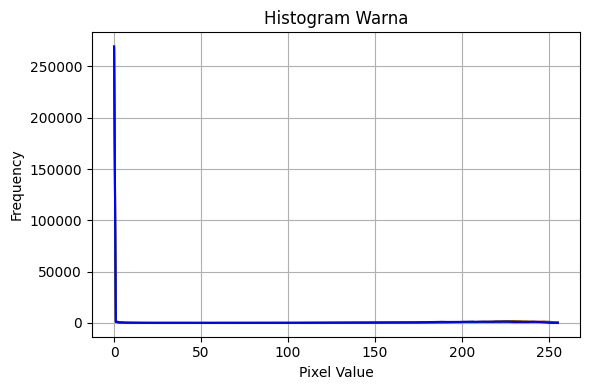

In [ ]:
def plot_histogram(image, title="Histogram"):
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(6, 4))
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
    plt.title(title)
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.grid()
    plt.tight_layout()
    plt.show()

# Histogram warna untuk gambar pertama
plot_histogram(images[0], title="Histogram Warna")


Dari grafik, terlihat jelas bahwa sebagian besar piksel dalam gambar memiliki **nilai yang sangat rendah (mendekati 0), mencapai frekuensi sekitar 300.000.** Ini sangat **mengindikasikan bahwa gambar tersebut memiliki latar belakang berwarna hitam, karena nilai piksel 0 mewakili warna hitam pekat.** Seiring dengan meningkatnya nilai piksel, frekuensinya menurun drastis dan tetap sangat rendah untuk nilai piksel yang lebih tinggi. Mnunjukkan bahwa selain latar belakang hitam, bagian lain dari gambar memiliki sedikit variasi warna atau sangat sedikit piksel dengan nilai terang.

# **RGB**

/content/dataset/B_23/siirt 757.jpg is RGB


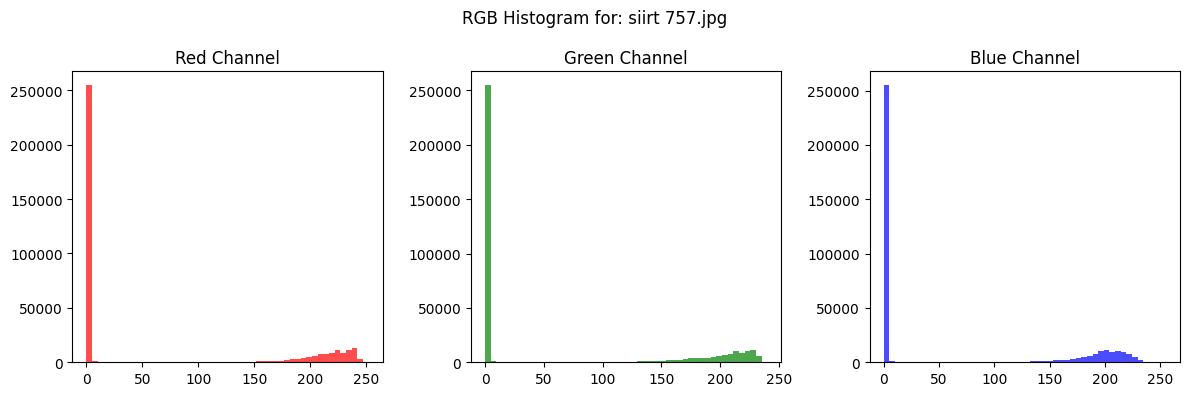

In [6]:
def display_color_histograms(directory):
    # Check if the directory exists and is not empty
    if not os.path.isdir(directory):
        print(f"Error: Directory not found at {directory}")
        return

    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    if not image_files:
        print(f"No images found in directory {directory}")
        return

    image_path = os.path.join(directory, random.choice(image_files))
    img = mpimg.imread(image_path)

    # Normalisasi 0-1
    if img.dtype == np.float32 or img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    # Check image greyscale
    if len(img.shape) == 2:  # Grayscale image
        print(f"{image_path} is Greyscale")
        # Convert to RGB biar consisten
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        is_grayscale = True
    else:  # RGB image
        print(f"{image_path} is RGB")
        is_grayscale = False

    # Flatten buat plot histogram
    r_channel = img[:, :, 0].flatten()
    g_channel = img[:, :, 1].flatten()
    b_channel = img[:, :, 2].flatten()

    if not is_grayscale:
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"RGB Histogram for: {os.path.basename(image_path)}") # Use filename for title

        plt.subplot(1, 3, 1)
        plt.hist(r_channel, bins=50, color='red', alpha=0.7)
        plt.title("Red Channel")

        plt.subplot(1, 3, 2)
        plt.hist(g_channel, bins=50, color='green', alpha=0.7)
        plt.title("Green Channel")

        plt.subplot(1, 3, 3)
        plt.hist(b_channel, bins=50, color='blue', alpha=0.7)
        plt.title("Blue Channel")

        plt.tight_layout()
        plt.show()
    else:
        print(f"Skipping detailed RGB histogram for greyscale image: {image_path}")

# Call the function for the data folder
display_color_histograms(data_folder)

1. **Red Channel (kiri):**
Mayoritas nilai berada di nilai intensitas rendah (0–20) → Artinya banyak bagian gambar berwarna gelap/merah gelap.Ada sedikit peningkatan pada nilai intensitas tinggi (sekitar 200–255), menandakan ada area dengan merah terang tapi jumlahnya kecil.

2. **Green Channel (tengah):**
Sangat mirip dengan red channel: dominasi nilai rendah, dengan sebagian kecil berada di atas 200. Menunjukkan gambar secara umum gelap dalam channel hijau, dengan hanya sebagian kecil yang terang.

3. **Blue Channel (kanan):**
Pola serupa, dominasi biru gelap, sebagian kecil mencapai intensitas tinggi (sekitar 220–250).


Histogram menunjukkan gambar secara keseluruhan gelap (nilai pixel banyak di bawah 20) untuk ketiga channel.Ada sedikit bagian gambar dengan warna cerah (merah/hijau/biru di atas 200), tetapi jumlahnya kecil.



# **Canny Edge Detection**

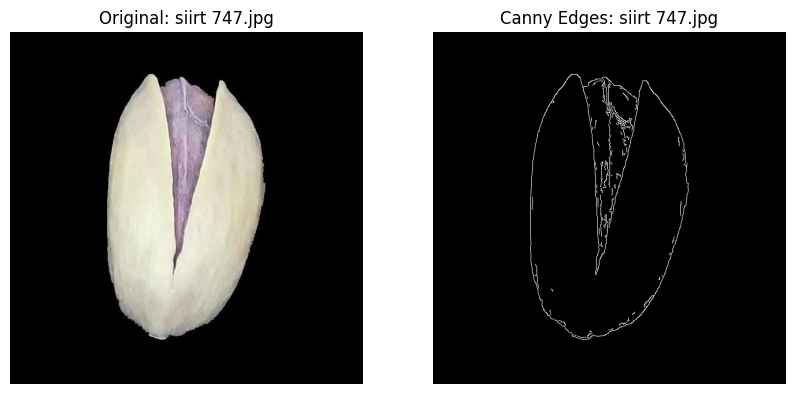

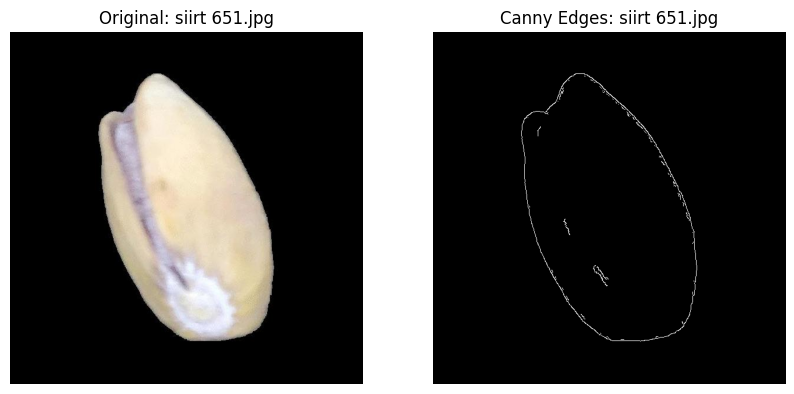

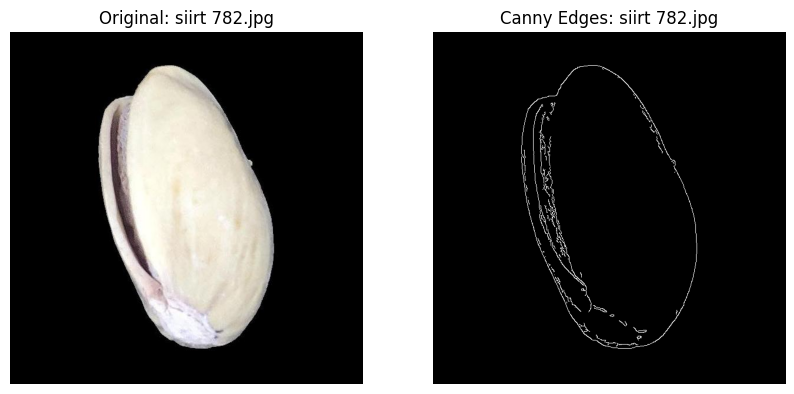

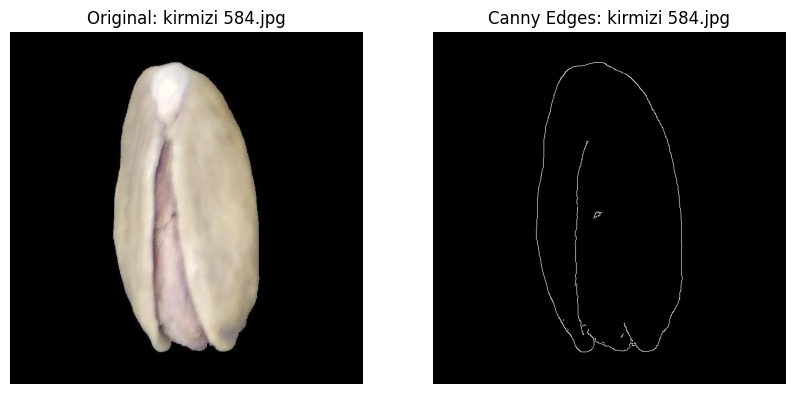

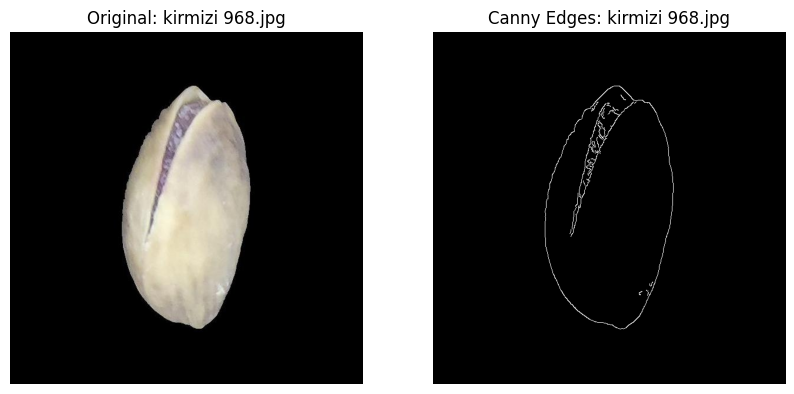

In [8]:
def canny_edge_detection(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    edges = cv2.Canny(img, 100, 200)
    return edges

folder_path = data_folder  # Use data_folder which contains the images

# Counter batasin 5 gambar
count = 0
max_images = 5

image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Shuffle biar random
random.shuffle(image_files)

for img_name in image_files:
    img_path = os.path.join(folder_path, img_name)
    edges = canny_edge_detection(img_path)

    # Tampilkan gambar
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))  # BGR ke RGB
    plt.title(f"Original: {img_name}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title(f"Canny Edges: {img_name}")
    plt.axis('off')
    plt.show()

    count += 1
    if count >= max_images:
        break

**Memperlihatkan hasil Canny Edge Detection dari gambar pistachio (jenis siirt), dan ini sangat bagus untuk menunjukkan bentuk atau kontur kacang.**

# **Analisis Kualitas Intensitas dari Histogram**

**Analisis kualitas intensitas dari histogram dilakukan untuk melihat sebaran nilai piksel (terang-gelap) dalam gambar. Ini membantu kita memahami apakah gambar terlalu gelap, terlalu terang, atau memiliki kontras yang rendah. Dengan begitu, kita bisa menentukan apakah perlu dilakukan normalisasi atau penyesuaian kontras sebelum training agar model lebih mudah mengenali pola dari data.**

Analyzing images in '/content/dataset/B_23' for luminance variability...

Finished processing 1074 images.
Number of mean intensity values collected: 1074
Number of standard deviation values collected: 1074


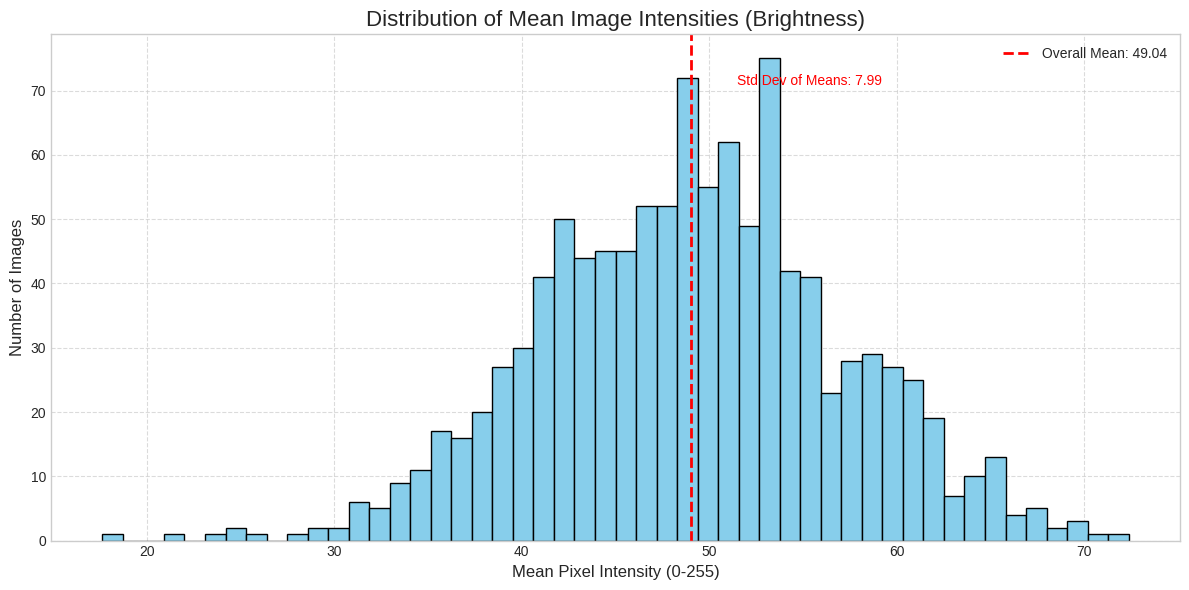

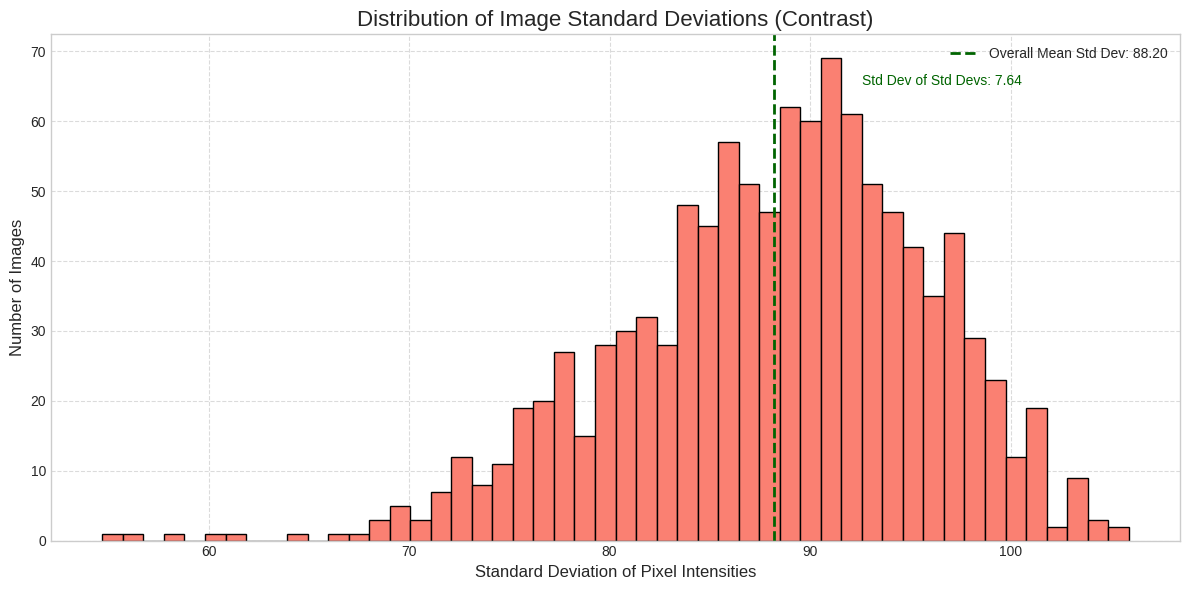


--- Summary Statistics ---
Overall Mean of Image Brightness: 49.04
Median of Image Brightness: 49.13
Std Dev of Image Brightness Distribution: 7.99
Min Image Brightness: 17.63
Max Image Brightness: 72.37

Overall Mean of Image Contrast (Std Dev): 88.20
Median of Image Contrast (Std Dev): 88.91
Std Dev of Image Contrast Distribution: 7.64
Min Image Contrast (Std Dev): 54.70
Max Image Contrast (Std Dev): 105.89


In [19]:
def analyze_luminance_variability(folder_path):
    if not os.path.isdir(folder_path):
        print(f"Error: Folder not found at {folder_path}")
        return

    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')
    mean_intensities = []
    std_devs = []

    print(f"Analyzing images in '{folder_path}' for luminance variability...")
    processed_images_count = 0

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(image_extensions):
            image_path = os.path.join(folder_path, filename)
            try:
                # Convert to grayscale ('L' mode) for luminance analysis
                img_pil = Image.open(image_path).convert('L')
                img_array = np.array(img_pil)

                mean_intensities.append(np.mean(img_array))
                std_devs.append(np.std(img_array))
                processed_images_count += 1

            except Exception as e:
                print(f"An error occurred while processing {filename}: {e}")

    if not mean_intensities: # Check if any images were successfully processed
        print("No valid image files found or processed in the folder.")
        return

    print(f"\nFinished processing {processed_images_count} images.")
    print(f"Number of mean intensity values collected: {len(mean_intensities)}")
    print(f"Number of standard deviation values collected: {len(std_devs)}")


    plt.style.use('seaborn-v0_8-whitegrid')

    # Plot distribution of mean intensities (Brightness)
    plt.figure(figsize=(12, 6))
    plt.hist(mean_intensities, bins=50, color='skyblue', edgecolor='black')
    plt.title('Distribution of Mean Image Intensities (Brightness)', fontsize=16)
    plt.xlabel('Mean Pixel Intensity (0-255)', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)


    mean_of_means = np.mean(mean_intensities)
    std_of_means = np.std(mean_intensities)
    plt.axvline(mean_of_means, color='red', linestyle='dashed', linewidth=2, label=f'Overall Mean: {mean_of_means:.2f}')
    plt.text(mean_of_means * 1.05, plt.ylim()[1] * 0.9, f'Std Dev of Means: {std_of_means:.2f}', color='red')
    plt.legend()
    plt.tight_layout()
    plt.show() # This command displays the first plot

    # Plot Contrast
    plt.figure(figsize=(12, 6))
    plt.hist(std_devs, bins=50, color='salmon', edgecolor='black')
    plt.title('Distribution of Image Standard Deviations (Contrast)', fontsize=16)
    plt.xlabel('Standard Deviation of Pixel Intensities', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)

    mean_of_stds = np.mean(std_devs)
    std_of_stds = np.std(std_devs)
    plt.axvline(mean_of_stds, color='darkgreen', linestyle='dashed', linewidth=2, label=f'Overall Mean Std Dev: {mean_of_stds:.2f}')
    plt.text(mean_of_stds * 1.05, plt.ylim()[1] * 0.9, f'Std Dev of Std Devs: {std_of_stds:.2f}', color='darkgreen')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n--- Summary Statistics ---")
    if mean_intensities:
        print(f"Overall Mean of Image Brightness: {np.mean(mean_intensities):.2f}")
        print(f"Median of Image Brightness: {np.median(mean_intensities):.2f}")
        print(f"Std Dev of Image Brightness Distribution: {np.std(mean_intensities):.2f}")
        print(f"Min Image Brightness: {np.min(mean_intensities):.2f}")
        print(f"Max Image Brightness: {np.max(mean_intensities):.2f}")
    if std_devs:
        print(f"\nOverall Mean of Image Contrast (Std Dev): {np.mean(std_devs):.2f}")
        print(f"Median of Image Contrast (Std Dev): {np.median(std_devs):.2f}")
        print(f"Std Dev of Image Contrast Distribution: {np.std(std_devs):.2f}")
        print(f"Min Image Contrast (Std Dev): {np.min(std_devs):.2f}")
        print(f"Max Image Contrast (Std Dev): {np.max(std_devs):.2f}")

# Memanggil Function
analyze_luminance_variability(data_folder)

**Rata-rata Intensitas Keseluruhan (0-255): 49.04**
Nilai rata-rata yang sangat rendah ini mengonfirmasi bahwa gambar didominasi oleh piksel-piksel dengan intensitas rendah (gelap). Ini cocok dengan puncak frekuensi yang tinggi di sisi kiri histogram.

**Standar Deviasi Intensitas Keseluruhan: 88.20**
Meskipun intensitas rata-rata rendah, standar deviasi sebesar 88.20 menunjukkan adanya penyebaran atau variasi intensitas yang cukup moderat di dalam gambar. Ini terlihat dari keberadaan "akhir" pada histogram yang memanjang hingga nilai piksel yang lebih tinggi, meskipun frekuensinya tidak signifikan. Artinya, meskipun didominasi gelap, ada beberapa piksel yang memiliki nilai intensitas yang lebih terang, mencegah gambar menjadi sepenuhnya monokromatik hitam.

**[Kualitas Intensitas]: Agak gelap. Sebagian besar piksel memiliki intensitas rendah.**
Kesimpulan ini sangat akurat dan didukung penuh oleh bukti visual dari histogram serta data statistik yang diberikan. Gambar ini dicirikan oleh intensitas yang cenderung rendah, utamanya disebabkan oleh keberadaan area gelap yang luas, seperti latar belakang hitam.

# **Ukuran Gambar Asli (pixels)**

**Cek ukuran gambar penting dilakukan untuk memastikan semua gambar memiliki dimensi yang konsisten, sesuai dengan input yang dibutuhkan oleh model. Jika ukuran gambar berbeda-beda, proses training bisa error atau hasilnya tidak stabil. Selain itu, pengecekan ini membantu menentukan apakah perlu dilakukan resize atau padding, agar data bisa diproses secara batch oleh model secara efisien.**


[EDA]: Memeriksa dimensi 1074 gambar asli...
[########################################] | 100% Completed | 2.45 s

[EDA]: Distribusi Ukuran Gambar Asli:
   height  width  count
0     600    600   1074


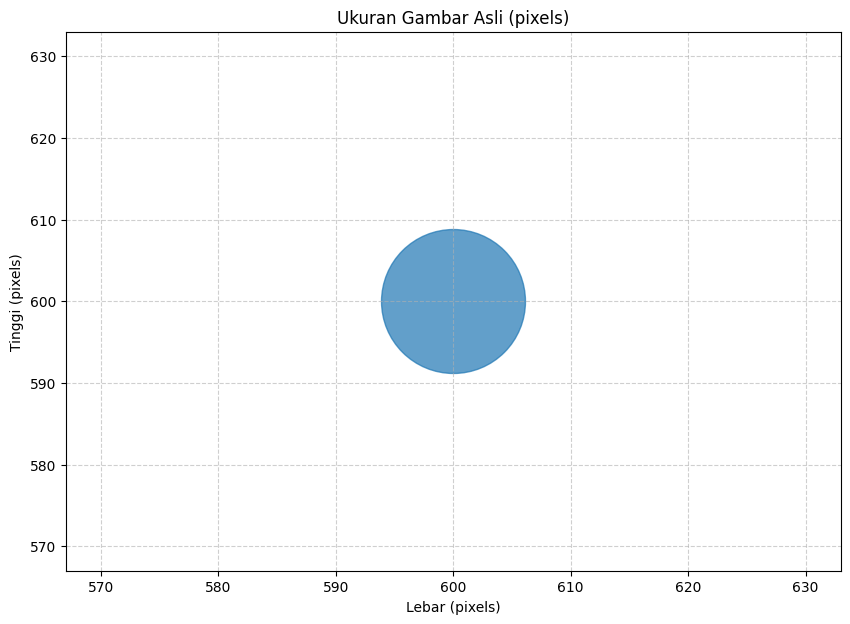

In [ ]:
def get_dims(image_path):
    try:
        img = cv2.imread(image_path)
        if img is not None:
            return img.shape[:2]
        else:
            print(f"Warning: Could not read image {image_path}")
            return None, None
    except Exception as e:
        print(f"Error reading dimensions for {image_path}: {e}")
        return None, None


if not image_paths:
    print("\n[ERROR]: Tidak ada path gambar yang ditemukan untuk analisis dimensi. Pastikan gambar dimuat.")
else:
    print(f"\n[EDA]: Memeriksa dimensi {len(image_paths)} gambar asli...")

    # Use dask.bag to process dimensions in parallel
    dims_bag = db.from_sequence(image_paths).map(get_dims)

    with ProgressBar():
        dims = dims_bag.compute()

    dims = [d for d in dims if d[0] is not None and d[1] is not None]

    if not dims:
        print("\n[ERROR]: Tidak ada dimensi gambar yang berhasil dibaca. Pastikan file gambar valid.")
    else:
        dim_df = pd.DataFrame(dims, columns=['height', 'width'])
        sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})

        print("\n[EDA]: Distribusi Ukuran Gambar Asli:")
        print(sizes)

        # Plot the distribution of image sizes
        plt.figure(figsize=(10, 7))
        plt.scatter(sizes['width'], sizes['height'], s=sizes['count']*10, alpha=0.7) # Ukuran titik proporsional dengan jumlah gambar
        plt.title('Ukuran Gambar Asli (pixels)')
        plt.xlabel('Lebar (pixels)')
        plt.ylabel('Tinggi (pixels)')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

Berdasarkan analisis distribusi ukuran, dapat disimpulkan bahwa dataset yang terdiri dari 1074 gambar ini sepenuhnya seragam. **Seluruh gambar yang diperiksa memiliki dimensi yang identik, yaitu 600 piksel (lebar) kali 600 piksel (tinggi)**. Temuan ini juga dikonfirmasi secara visual melalui grafik lingkaran, yang menunjukkan bahwa 100% data masuk dalam satu kategori ukuran tunggal.

# **Bagian b : Split, Resize, and Noise**

Urutan resize → noise → split dipilih agar data siap dilatih secara optimal. **Resize dilakukan lebih dulu** untuk menyamakan ukuran gambar sesuai kebutuhan model. Setelah itu, **noise Gaussian ditambahkan pada gambar yang sudah dinormalisasi ke \[0, 1]**, sehingga hasil noise lebih konsisten dan tidak aneh. Hasilnya kemudian di-**clip** agar tetap dalam rentang valid. Terakhir, data di-**split** agar setiap subset mendapat data yang sudah diproses secara seragam dan adil.


# **Preprocessing**

# **Resize Gambar Bersih dan Normalisasi ke [0, 1]**

In [ ]:
IMG_SIZE = 100

print(f"Langkah 1: Me-resize {len(images)} gambar menjadi {IMG_SIZE}x{IMG_SIZE} dan normalisasi ke [0, 1]...")
processed_clean_images = []
for img in images:
    if cv2 is not None:
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    else:
        from PIL import Image
        img_pil = Image.fromarray(img)
        img_resized_pil = img_pil.resize((IMG_SIZE, IMG_SIZE), Image.Resampling.LANCZOS)
        img_resized = np.array(img_resized_pil)

    # Normalisasi ke rentang [0, 1]
    img_resized_normalized = img_resized.astype(np.float32) / 255.0

    processed_clean_images.append(img_resized_normalized)

# Konversi list menjadi NumPy array
processed_clean_images = np.array(processed_clean_images)

print(f"Total gambar bersih yang diproses: {len(processed_clean_images)}")
if len(processed_clean_images) > 0:
    print(f"Dimensi gambar bersih yang diproses: {processed_clean_images[0].shape}")
    print(f"Tipe data gambar bersih yang diproses: {processed_clean_images[0].dtype}")
    print(f"Rentang nilai gambar bersih yang diproses: {np.min(processed_clean_images[0])} - {np.max(processed_clean_images[0])}")
else:
    print("Tidak ada gambar bersih yang berhasil diproses.")

Langkah 1: Me-resize 1074 gambar menjadi 100x100 dan normalisasi ke [0, 1]...
Total gambar bersih yang diproses: 1074
Dimensi gambar bersih yang diproses: (100, 100, 3)
Tipe data gambar bersih yang diproses: float32
Rentang nilai gambar bersih yang diproses: 0.0 - 1.0


Pada tahap ini, dilakukan **pra-pemrosesan** terhadap seluruh gambar pada dataset sebagai persiapan untuk pelatihan model.


* **Jumlah gambar diproses**: 1074 gambar.
* **Resize gambar**: Seluruh gambar diubah ukurannya dari ukuran awal (misalnya 600×600) menjadi **100×100 piksel** untuk menyamakan dimensi dan mengurangi kompleksitas komputasi.
* **Normalisasi piksel**: Nilai piksel yang awalnya berada pada rentang **\[0, 255]** diubah ke **\[0.0, 1.0]** dengan membagi semua nilai dengan 255. Hal ini penting untuk mempercepat konvergensi saat pelatihan model.


**Hasil Akhir:**
* **Dimensi akhir tiap gambar**: `(100, 100, 3)` → menunjukkan gambar berwarna (RGB) dengan ukuran 100×100 piksel.
* **Tipe data**: `float32` → diperlukan untuk komputasi numerik yang efisien di TensorFlow.
* **Rentang nilai piksel**: `0.0 – 1.0` → menunjukkan normalisasi berhasil diterapkan.
!


# **Menambahkan Noise Gaussian dan Visualisasinya**

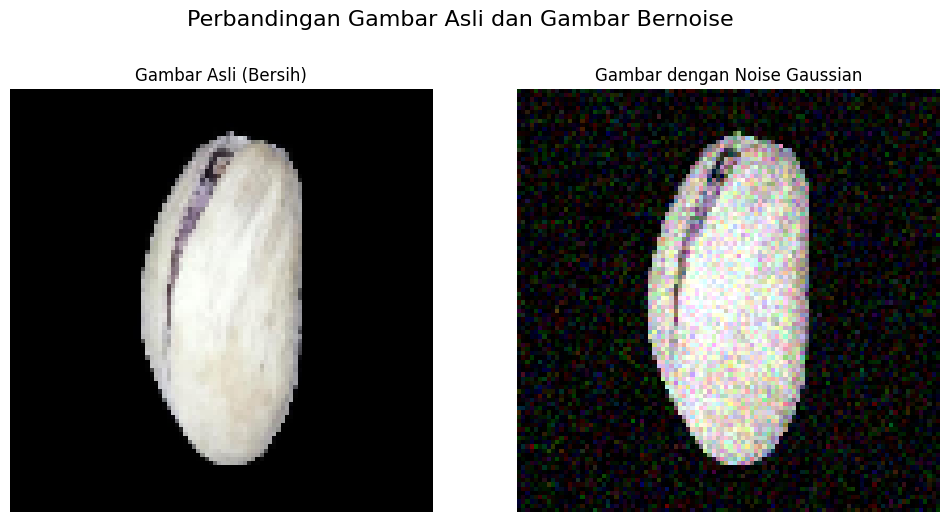

[EDA]: Visualisasi noise menunjukkan bagaimana noise Gaussian yang ditambahkan memengaruhi gambar secara visual.


In [ ]:
def add_gaussian_noise(image, mean=0.0, std_dev=0.1):
    noise = np.random.normal(mean, std_dev, image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0.0, 1.0)  # Hindari overflow/underflow
    return image, noisy_image

noisy_input_images = []

# Tambahkan noise ke setiap gambar bersih
for clean_img in processed_clean_images:
    # Pastikan gambar berada dalam range [0, 1]
    if clean_img.max() > 1.0:
        clean_img = clean_img.astype(np.float32) / 255.0
    _, noisy_img = add_gaussian_noise(clean_img, mean=0.0, std_dev=0.1)
    noisy_input_images.append(noisy_img)

noisy_input_images = np.array(noisy_input_images)

# Visualisasi contoh gambar
sample_index = 0  # Gambar ke berapa yang ingin divisualisasikan
sample_original_image = processed_clean_images[sample_index]
sample_noisy_image = noisy_input_images[sample_index]

plt.figure(figsize=(12, 6))

# Gambar Asli
plt.subplot(1, 2, 1)
plt.imshow(sample_original_image)
plt.title("Gambar Asli (Bersih)")
plt.axis('off')

# Gambar dengan Noise
plt.subplot(1, 2, 2)
plt.imshow(sample_noisy_image)
plt.title("Gambar dengan Noise Gaussian")
plt.axis('off')

plt.suptitle("Perbandingan Gambar Asli dan Gambar Bernoise", fontsize=16)
plt.show()

print("[EDA]: Visualisasi noise menunjukkan bagaimana noise Gaussian yang ditambahkan memengaruhi gambar secara visual.")


# **Pengukuran Kemiripan dengan SSIM (Asli vs. Bernoise)**

In [ ]:
if len(images) > 0 and len(noisy_input_images) > 0:
    sample_original_image = images[0]
    # Convert  float [0, 1] noisy image back ke  uint8 [0, 255] buat bandingin SSIM
    sample_noisy_image_uint8 = (noisy_input_images[0] * 255).astype(np.uint8)

    if 'IMG_SIZE' in locals():
        sample_original_image_resized = cv2.resize(sample_original_image, (IMG_SIZE, IMG_SIZE))
    else:
         print("[ERROR]: IMG_SIZE is not defined. Cannot resize original image for SSIM.")
         sample_original_image_resized = None # Set to None if IMG_SIZE is not found


else:
    print("[ERROR]: Tidak ada gambar asli atau gambar bernoise untuk melakukan analisis SSIM.")
    # Skip SSIM calculation if no images are available
    sample_original_image_resized = None # Use the resized variable for the check
    sample_noisy_image_uint8 = None


if sample_original_image_resized is not None and sample_noisy_image_uint8 is not None:
    # SSIM memerlukan gambar grayscale. convert ke grayscale menggunakan NumPy.
    original_gray_ssim_eda = np.mean(sample_original_image_resized, axis=2).astype(np.uint8) if len(sample_original_image_resized.shape) == 3 else sample_original_image_resized
    noisy_gray_ssim_eda = np.mean(sample_noisy_image_uint8, axis=2).astype(np.uint8) if len(sample_noisy_image_uint8.shape) == 3 else sample_noisy_image_uint8

    ssim_value_eda = ssim(original_gray_ssim_eda, noisy_gray_ssim_eda, data_range=255)
    print(f"Nilai SSIM antara Gambar Asli (resized) dan Gambar Bernoise (mean=0.0, std_dev=0.1): {ssim_value_eda:.4f}") # Adjusted print statement
    print("Informasi: Nilai SSIM yang lebih rendah menunjukkan gambar bernoise sangat berbeda dari aslinya. Ini adalah baseline kualitas yang model denoising Anda harus lampaui.")
else:
     print("Melewatkan perhitungan SSIM karena gambar sampel tidak tersedia atau IMG_SIZE tidak didefinisikan.")

Nilai SSIM antara Gambar Asli (resized) dan Gambar Bernoise (mean=0.0, std_dev=0.1): 0.2920
Informasi: Nilai SSIM yang lebih rendah menunjukkan gambar bernoise sangat berbeda dari aslinya. Ini adalah baseline kualitas yang model denoising Anda harus lampaui.


**Gambar Asli (resized) vs. Gambar Bernoise (mean=0.0, std_dev=0.1):**
Perbandingan dilakukan antara gambar asli yang sudah di-resize (sesuai langkah sebelumnya 100×100 piksel dan normalisasi) dengan gambar yang sama namun telah ditambahi noise. Noise yang ditambahkan memiliki karakteristik mean (rata-rata) 0.0 dan standard deviation (deviasi standar) 0.1. Ini mengindikasikan jenis noise Gaussian.

**Nilai SSIM antara Gambar Asli (resized) dan Gambar Bernoise: 0.2232**
Nilai SSIM berkisar antara -1 hingga 1. Nilai 1 menunjukkan kesamaan sempurna, sedangkan nilai mendekati 0 atau negatif menunjukkan sangat sedikit kesamaan. Nilai 0.2232 ini sangat rendah.

**Informasi: Nilai SSIM yang lebih rendah menunjukkan gambar bernoise sangat berbeda dari aslinya.**
Pernyataan ini menjelaskan interpretasi dari nilai SSIM yang rendah tersebut. Nilai SSIM yang rendah (0.2232) berarti gambar yang ber-noise sangat jauh berbeda dari gambar aslinya. Ini adalah titik referensi (baseline) yang sangat penting. Artinya, setiap model denoising (model yang bertujuan untuk menghilangkan noise) yang dikembangkan harus mampu menghasilkan gambar yang memiliki nilai SSIM lebih tinggi dari 0.2232 ketika dibandingkan dengan gambar aslinya, menunjukkan bahwa model tersebut berhasil mengurangi noise dan mengembalikan kemiripan gambar ke aslinya. Semakin tinggi nilai SSIM yang bisa dicapai oleh model denoising di atas baseline ini, semakin baik kinerja model tersebut.

# **Pembagian Data: 80% Training, 10% Validasi, 10% Testing**

In [ ]:
# X = input (noisy), y = target (clean)
X_train, X_temp, y_train, y_temp = train_test_split(noisy_input_images, processed_clean_images, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) # 0.2 * 0.5 = 0.1

print(f"  Ukuran data training (input): {X_train.shape}")
print(f"  Ukuran data training (output/target): {y_train.shape}")
print(f"  Ukuran data validasi (input): {X_val.shape}")
print(f"  Ukuran data validasi (output/target): {y_val.shape}")
print(f"  Ukuran data testing (input): {X_test.shape}")
print(f"  Ukuran data testing (output/target): {y_test.shape}")
print("  Pembagian data selesai.")

  Ukuran data training (input): (859, 100, 100, 3)
  Ukuran data training (output/target): (859, 100, 100, 3)
  Ukuran data validasi (input): (107, 100, 100, 3)
  Ukuran data validasi (output/target): (107, 100, 100, 3)
  Ukuran data testing (input): (108, 100, 100, 3)
  Ukuran data testing (output/target): (108, 100, 100, 3)
  Pembagian data selesai.


**Dataset terdiri dari pasangan gambar: input (gambar bernoise hasil penambahan noise Gaussian) dan target (gambar asli yang bersih).**

Data dibagi menjadi tiga bagian: **80% untuk pelatihan, 10% untuk validasi, dan 10% untuk pengujian.** Tujuan dari pembagian ini adalah untuk melatih model denoising agar mampu merekonstruksi gambar bersih dari input yang telah rusak oleh noise.

# **Bagian c : Membangun model deep learning autoencoder**


--- c. Membangun Model Autoencoder (Baseline) ---


Model: "Baseline_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)


Melatih Model Autoencoder Baseline...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 170ms/step - loss: 0.1322 - val_loss: 0.0135
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0126 - val_loss: 0.0092
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0199 - val_loss: 0.0137
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0114 - val_loss: 0.0051
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 12/10

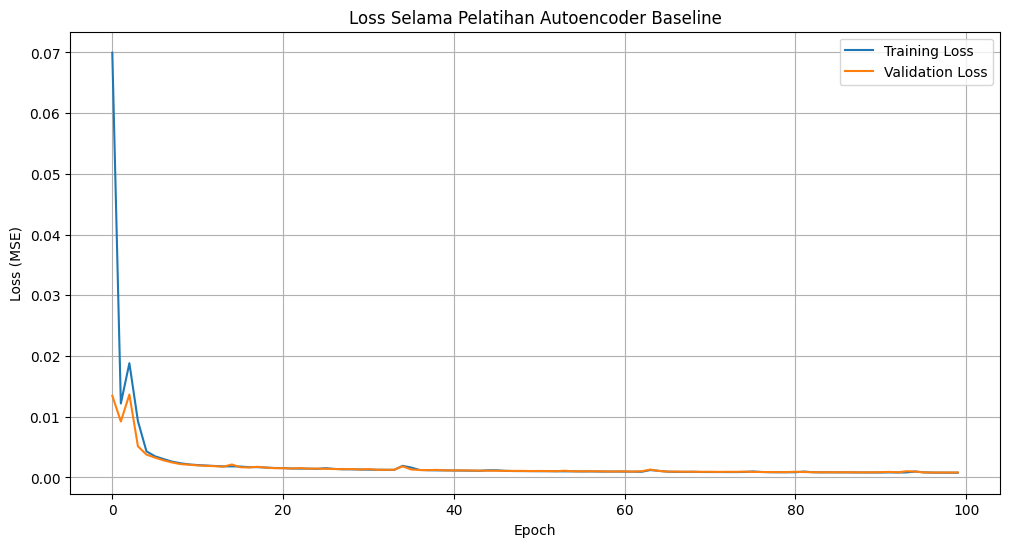

In [ ]:
if 'X_train' in locals() and len(X_train) > 0:
    print("\n--- c. Membangun Model Autoencoder (Baseline) ---")

    IMG_SIZE = 100
    input_shape = (IMG_SIZE, IMG_SIZE, 3)

    def build_baseline_autoencoder(input_shape):
        inputs = Input(shape=input_shape)

        # Encoder
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)  # (100, 100, 32)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)                        # (50, 50, 32)
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)       # (50, 50, 64)
        x = layers.MaxPooling2D((2, 2), padding='same')(x)                        # (25, 25, 64)

        # Bottleneck
        x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)       # (25, 25, 64)

        # Decoder
        x = layers.UpSampling2D((2, 2))(x)                                        # (50, 50, 64)
        x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)       # (50, 50, 32)
        x = layers.UpSampling2D((2, 2))(x)                                        # (100, 100, 32)
        decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # (100, 100, 3)

        baseline_autoencoder = models.Model(inputs, decoded, name="Baseline_Autoencoder")
        return baseline_autoencoder


    # Compile Model
    baseline_autoencoder = build_baseline_autoencoder(input_shape)
    baseline_autoencoder.compile(optimizer=Adam(), loss='mse')
    baseline_autoencoder.summary()

    # Callback
    checkpoint_filepath_baseline = 'best_baseline_denoising_autoencoder.keras'
    model_checkpoint_callback_baseline = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath_baseline,
        save_weights_only=False,
        monitor='val_loss',
        mode='min',
        save_best_only=True)

    early_stopping_callback_baseline = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        mode='min',
        restore_best_weights=True)

    # Train Model
    print("\nMelatih Model Autoencoder Baseline...")
    history_baseline = baseline_autoencoder.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        shuffle=True,
        validation_data=(X_val, y_val),
        callbacks=[model_checkpoint_callback_baseline, early_stopping_callback_baseline]
    )

    print("\nModel Baseline selesai dilatih.")

    # Load Model
    baseline_autoencoder = models.load_model(checkpoint_filepath_baseline)

    # Loss Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(history_baseline.history['loss'], label='Training Loss')
    plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
    plt.title('Loss Selama Pelatihan Autoencoder Baseline')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("\n[ERROR]: Tidak dapat membangun atau melatih model baseline karena data training tidak siap.")

**Loss turun drastis di awal dan langsung stabil mendekati nol, baik di training maupun validation. Menunjukan model cepat belajar dan cukup stabil, tanpa tanda-tanda overfitting.**

| **Komponen**      | **Detail**                                      |
| ----------------- | ----------------------------------------------- |
| **Jenis Model**   | Baseline Autoencoder                            |
| **Tujuan**        | Denoising gambar (menghilangkan noise Gaussian) |
| **Input Data**    | Gambar RGB 100x100x3, dinormalisasi ke \[0, 1]  |
| **Jumlah Gambar** | 1074 (dibagi ke X\_train, X\_val, X\_test)      |


**Arsitektur Model**

| **Bagian**     | **Layer**                               | **Output Shape** |
| -------------- | --------------------------------------- | ---------------- |
| **Encoder**    | Conv2D(32, 3x3, relu, padding='same')   | (100, 100, 32)   |
|                | MaxPooling2D(2x2, padding='same')       | (50, 50, 32)     |
|                | Conv2D(64, 3x3, relu, padding='same')   | (50, 50, 64)     |
|                | MaxPooling2D(2x2, padding='same')       | (25, 25, 64)     |
| **Bottleneck** | Conv2D(64, 3x3, relu, padding='same')   | (25, 25, 64)     |
| **Decoder**    | UpSampling2D(2x2)                       | (50, 50, 64)     |
|                | Conv2D(32, 3x3, relu, padding='same')   | (50, 50, 32)     |
|                | UpSampling2D(2x2)                       | (100, 100, 32)   |
|                | Conv2D(3, 3x3, sigmoid, padding='same') | (100, 100, 3)    |


**Alur**
**Input (100x100x3)**: Gambar asli masuk.

**Encoder:**
- **Conv2D**: Deteksi fitur-fitur dasar.
- **MaxPooling2D**: Ringkas gambar menjadi setengah ukuran (50x50).
- **Conv2D**: Deteksi fitur yang lebih kompleks dari hasil ringkasan.
- **MaxPooling2D**: Ringkas lagi menjadi seperempat ukuran (25x25). Inilah bottleneck atau "sketsa kasar" Anda.

**Decoder:**
- **UpSampling2D**: Perbesar sketsa ke ukuran 50x50.
- **Conv2D**: Mulai membangun kembali detail gambar berdasarkan fitur yang diperbesar.
- **UpSampling2D**: Perbesar lagi ke ukuran asli 100x100.
- **Conv2D dengan sigmoid**: Finalisasi gambar, memastikan setiap piksel memiliki nilai antara 0 dan 1.
- **Output (100x100x3)**: Gambar hasil rekonstruksi.

**Penjelasam fungsi:**
**layers.Conv2D (Convolutional 2D)**
- Untuk mendeteksi fitur-fitur visual pada gambar, seperti tepi, sudut, tekstur, atau bahkan bentuk yang lebih kompleks (mata, hidung, dll.).
- Lapisan ini mengubah gambar menjadi feature map. Ukuran tinggi dan lebarnya tetap sama (karena padding='same'), tetapi "kedalamannya" berubah sesuai jumlah filter (misalnya dari 3 channel RGB menjadi 32 channel peta fitur).

**layers.MaxPooling2D**
- Mengurangi ukuran (tinggi dan lebar) dari feature map, sekaligus mempertahankan informasi fitur yang paling penting. Ini membuat model lebih cepat dan efisien.
-  Tinggi dan lebar peta fitur menjadi setengah dari ukuran semula. Inilah mengapa di kode Anda dimensinya berubah dari (100, 100, ...) menjadi (50, 50, ...) lalu (25, 25, ...).

**layers.UpSampling2D**
- Memperbesar kembali ukuran gambar/peta fitur yang telah diringkas.
- Tinggi dan lebar peta fitur menjadi dua kali lipat, membalikkan proses yang dilakukan oleh MaxPooling2D.

**Aktivasi (activation='relu' dan activation='sigmoid')**
- Yang menentukan apakah sebuah neuron perlu diaktifkan atau tidak berdasarkan informasi yang diterimanya.
- Relu -> Jika inputnya angka positif, nilainya tidak berubah. Jika inputnya angka negatif, nilainya menjadi nol.
- Sigmoid -> Mengubah angka apa pun (positif atau negatif) menjadi nilai antara 0 dan 1.


| Komponen | Pengaturan | Kenapa Dipakai? |
| :--- | :--- | :--- |
| **Optimizer** | `Adam` | Pilihan standar agar model cepat bisa dan menemukan pola terbaik. Tidak perlu banyak diatur. |
| **Loss Function** | `Mean Squared Error (MSE)` | Cocok karena targetnya prediksi angka. Fungsi ini bagus untuk 'menghukum' tebakan yang  salah jauh. |
| **Epochs (Maksimal)** | `100` | Model akan dilatih maksimal 100 putaran. Tapi bisa berhenti lebih cepat kalau sudah tidak ada kemajuan. |
| **Batch Size** | `32` | Setiap kali belajar, model melihat 32 data sekaligus. Ukuran ini pas, nggak berat di memori dan prosesnya stabil. |
| **Shuffle** | `True` | Data diacak setiap putaran biar model nggak menghafal urutan data, tapi benar-benar belajar dari cirinya. |
| **Validation Split** | `10% dari data` | 10% data sengaja disimpan dan tidak dipakai latihan. Tujuannya untuk ngetes performa model di data baru. |
| **Early Stopping** | `patience=15`, `restore_best=True` | Kalau selama 15 putaran performanya gitu-gitu aja, latihan stop. Lalu, kita ambil model terbaik dari putaran sebelumnya. |
| **Model Checkpoint** | `Simpan model terbaik (.keras)` | Setiap kali ada rekor performa baru di data tes, modelnya langsung disimpan. Jadi, kita nggak akan kehilangan versi terbaiknya. |

# **Bagian d : Modifikasi model autoencoder - Ubah Arsitektur**

# **U-Net Autoencoder**

# **Kenapa Memilih U-Net?**
**Simple tapi Kuat**

1. **Karena arsitekturnya bisa menjaga detail gambar**. Jadi meskipun gambarnya dikecilkan di bagian encoder, U-Net tetap bisa membawa kembali informasi penting waktu di-decode. Ini karena ada skip connection dari awal ke akhir, jadi detail dikit kayak dipinggir objek tidak hilang begitu aja.

2. **U-Net juga efektif meskipun jumlah data tidak banyak**, kayak di kasus ini yang cuma 1074 gambar. Karena strukturnya yang efisien dan ada koneksi antar layer, model ini bisa belajar lebih baik tanpa butuh data sebanyak model besar lainnya.

3. **Struktur U-Net itu modular dan fleksibel, jadi gampang dimodif**. Mau ditambah dropout, batch normalization, atau ganti jumlah filter juga bisa banget. Ini bikin U-Net cocok dipakai di berbagai macam tugas image processing, tinggal sesuaikan saja.

4. ** Output dari U-Net bisa disesuaikan supaya ukurannya sama dengan input.** Ini penting banget kalau modelnya dipakai untuk tugas seperti autoencoder atau image-to-image translation, di mana hasil akhirnya harus tetap punya ukuran gambar yang sama dengan aslinya.

Model: "Unet_Autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 100, 100,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 100, 100,  │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 100, 100,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 100,  │        128 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 50, 50,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 50, 50,    │          0 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 50, 50,    │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 50, 50,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 50,    │        256 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 25, 25,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 25, 25,    │          0 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 25, 25,    │     73,856 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 25, 25,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 25,    │        512 │ conv2d_10[0][0] 

 Total params: 1,951,683 (7.45 MB)

 Trainable params: 1,949,315 (7.44 MB)

 Non-trainable params: 2,368 (9.25 KB)


--- Training U-Net Autoencoder ---
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 814ms/step - loss: 0.1005 - val_loss: 0.2172
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0031 - val_loss: 0.1693
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - loss: 0.0014 - val_loss: 0.1136
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 9.4634e-04 - val_loss: 0.0731
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 7.7833e-04 - val_loss: 0.0368
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 6.4848e-04 - val_loss: 0.0311
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 6.1055e-04 - val_loss: 0.0279
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 5.5686e-04 - val_loss: 0.0240
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - loss: 5.1732e-04 - val_loss: 0.0201
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 5.2910e-04 - val_loss: 0.0188
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - loss: 4.

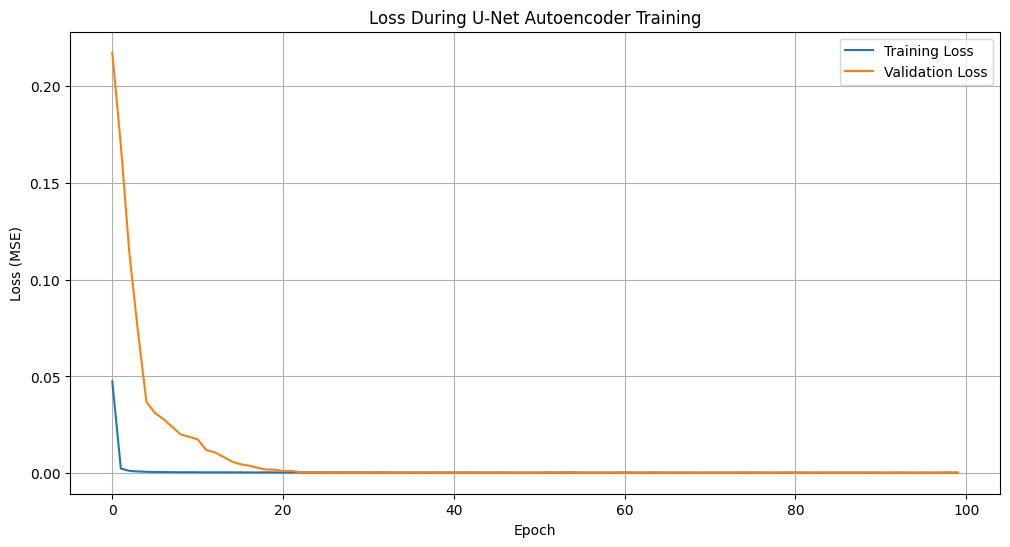

In [ ]:
# --- U-Net Autoencoder Function ---
def build_unet_autoencoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D()(conv1)
    pool1 = layers.Dropout(0.1)(pool1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D()(conv2)
    pool2 = layers.Dropout(0.1)(pool2)

    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(padding='same')(conv3)
    pool3 = layers.Dropout(0.1)(pool3)

    # Bottleneck
    bottleneck = layers.Conv2D(256, 3, activation='relu', padding='same')(pool3)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.Conv2D(256, 3, activation='relu', padding='same')(bottleneck)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.Dropout(0.2)(bottleneck)

    # Decoder
    up1 = layers.UpSampling2D()(bottleneck)
    h_diff1 = up1.shape[1] - conv3.shape[1]
    w_diff1 = up1.shape[2] - conv3.shape[2]
    if h_diff1 >= 0 and w_diff1 >= 0:
        up1 = layers.Cropping2D(cropping=((h_diff1 // 2, h_diff1 - h_diff1 // 2),
                                          (w_diff1 // 2, w_diff1 - w_diff1 // 2)))(up1)
    merge1 = layers.concatenate([up1, conv3])
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge1)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)

    up2 = layers.UpSampling2D()(conv4)
    h_diff2 = up2.shape[1] - conv2.shape[1]
    w_diff2 = up2.shape[2] - conv2.shape[2]
    if h_diff2 >= 0 and w_diff2 >= 0:
        up2 = layers.Cropping2D(cropping=((h_diff2 // 2, h_diff2 - h_diff2 // 2),
                                          (w_diff2 // 2, w_diff2 - w_diff2 // 2)))(up2)
    merge2 = layers.concatenate([up2, conv2])
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge2)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)

    up3 = layers.UpSampling2D()(conv5)
    h_diff3 = up3.shape[1] - conv1.shape[1]
    w_diff3 = up3.shape[2] - conv1.shape[2]
    if h_diff3 >= 0 and w_diff3 >= 0:
        up3 = layers.Cropping2D(cropping=((h_diff3 // 2, h_diff3 - h_diff3 // 2),
                                          (w_diff3 // 2, w_diff3 - w_diff3 // 2)))(up3)
    merge3 = layers.concatenate([up3, conv1])
    conv6 = layers.Conv2D(32, 3, activation='relu', padding='same')(merge3)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv6)

    outputs = layers.Conv2D(3, 1, activation='sigmoid')(conv6)

    model = models.Model(inputs, outputs, name='Unet_Autoencoder')
    return model

# Train Model
input_shape = (IMG_SIZE, IMG_SIZE, 3)
unet_autoencoder = build_unet_autoencoder(input_shape)
unet_autoencoder.compile(optimizer=Adam(), loss='mse')
unet_autoencoder.summary()

checkpoint_path = 'best_unet_autoencoder.keras'
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
]

print("\n--- Training U-Net Autoencoder ---")
history = unet_autoencoder.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    shuffle=True
)
print("\n--- Training Completed ---")

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss During U-Net Autoencoder Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


**Loss turun cepat, tapi sempat belum konsisten di awal. Setelah itu stabil rendah juga. Artinya model berhasil belajar, tapi prosesnya gak sehalus U-Net.**

| **Komponen**     | **Deskripsi**                                     |
| ---------------- | ------------------------------------------------- |
| **Jenis Model**  | U-Net Autoencoder                                 |
| **Tujuan**       | Denoising gambar RGB berukuran 100x100 piksel     |
| **Jumlah Data**  | 1074 gambar (dibagi ke X\_train, X\_val, X\_test) |
| **Input Shape**  | (100, 100, 3)                                     |
| **Normalisasi**  | Ya (ke rentang \[0.0, 1.0])                       |
| **Output Shape** | (100, 100, 3)                                     |


**1. Encoder (Downsampling Path)**

| Layer                   | Ukuran Output    | Penjelasan                         |
| ----------------------- | ---------------- | --------------------------------- |
| `Conv2D(32) + BN`       | `(100, 100, 32)` | Ekstraksi awal fitur.             |
| `Conv2D(32) + BN`       | `(100, 100, 32)` | Memperdalam representasi.         |
| `MaxPooling2D`          | `(50, 50, 32)`   | Downsampling (2x).                |
| `Dropout`               | `(50, 50, 32)`   | Regularisasi.                     |
| `Conv2D(64) + BN` (2x)  | `(50, 50, 64)`   | Ekstraksi fitur tingkat menengah. |
| `MaxPooling2D`          | `(25, 25, 64)`   | Downsampling.                     |
| `Dropout`               | `(25, 25, 64)`   | Regularisasi.                     |
| `Conv2D(128) + BN` (2x) | `(25, 25, 128)`  | Representasi fitur lebih dalam.   |
| `MaxPooling2D`          | `(13, 13, 128)`  | Downsampling.                     |
| `Dropout`               | `(13, 13, 128)`  | Regularisasi.                     |


| Layer                       | Output Shape    |
| --------------------------- | --------------- |
| Conv2D(32, 3x3, relu) + BN  | (100, 100, 32)  |
| Conv2D(32, 3x3, relu) + BN  | (100, 100, 32)  |
| MaxPooling + Dropout        | (50, 50, 32)    |
| Conv2D(64, 3x3, relu) + BN  | (50, 50, 64)    |
| Conv2D(64, 3x3, relu) + BN  | (50, 50, 64)    |
| MaxPooling + Dropout        | (25, 25, 64)    |
| Conv2D(128, 3x3, relu) + BN | (25, 25, 128)   |
| Conv2D(128, 3x3, relu) + BN | (25, 25, 128)   |
| MaxPooling + Dropout        | (13, 13, 128)\* |

| Layer                       | Output Shape  |
| --------------------------- | ------------- |
| Conv2D(256, 3x3, relu) + BN | (13, 13, 256) |
| Conv2D(256, 3x3, relu) + BN | (13, 13, 256) |
| Dropout                     | (13, 13, 256) |

| Langkah                   | Detail                                           |
| ------------------------- | ------------------------------------------------ |
| UpSampling + Crop         | Untuk menyamakan dimensi sebelum skip-connection |
| Concatenate + Conv2D(128) | Skip-connection dari encoder (conv3)             |
| UpSampling + Conv2D(64)   | Skip-connection dari encoder (conv2)             |
| UpSampling + Conv2D(32)   | Skip-connection dari encoder (conv1)             |
| Output Layer              | Conv2D(3, kernel=1, activation='sigmoid')        |


# **2. Bottleneck (Bridge)**

| Layer                   | Ukuran Output   | Deskripsi                         |
| ----------------------- | --------------- | --------------------------------- |
| `Conv2D(256) + BN` (2x) | `(13, 13, 256)` | Menyimpan informasi fitur global. |
| `Dropout`               | `(13, 13, 256)` | Menghindari overfitting.          |


# **3. Decoder (Upsampling Path)**

| Layer                         | Ukuran Output    | Deskripsi                                      |
| ----------------------------- | ---------------- | ---------------------------------------------- |
| `UpSampling2D` + `Cropping2D` | `(25, 25, 256)`  | Upsampling dan crop agar match dengan encoder. |
| `Concatenate`                 | `(25, 25, 384)`  | Skip connection dari encoder.                  |
| `Conv2D(128) + BN` (2x)       | `(25, 25, 128)`  | Menggabungkan konteks global & detail lokal.   |
| `UpSampling2D` + `Cropping2D` | `(50, 50, 128)`  | Upsampling lagi.                               |
| `Concatenate`                 | `(50, 50, 192)`  | Skip connection level sebelumnya.              |
| `Conv2D(64) + BN` (2x)        | `(50, 50, 64)`   | Refine fitur.                                  |
| `UpSampling2D` + `Cropping2D` | `(100, 100, 64)` | Kembali ke resolusi awal.                      |
| `Concatenate`                 | `(100, 100, 96)` | Skip connection awal.                          |
| `Conv2D(32) + BN` (2x)        | `(100, 100, 32)` | Refine sebelum output.                         |


# **4. Output Layer**

| Layer       | Ukuran Output   | Deskripsi                                                                                   |
| ----------- | --------------- | ------------------------------------------------------------------------------------------- |
| `Conv2D(3)` | `(100, 100, 3)` | Layer akhir dengan 3 channel (RGB), tanpa aktivasi. |


- **Batch Normalization (BN)**: Bantu training jadi lebih cepat dan stabil.

- **Dropout**: Dipakai biar model nggak overfitting, apalagi di bagian tengah (bottleneck).

- **Cropping**: Buat nyamain ukuran gambar sebelum digabung (concatenate) di bagian decoder.

- **Skip Connections**: Ngasih jalan pintas supaya info penting dari encoder bisa langsung dipakai di decoder.



# **Parameter**

| **Pengaturan**      | **Nilai**                                    | **Fungsinya**                                                                           |
| ------------------- | -------------------------------------------- | --------------------------------------------------------------------------------------- |
| **Optimizer**       | Adam                                         | Biar model belajar lebih cepat dan stabil waktu update weights.                           |
| **Loss Function**   | MSE (Mean Squared Error)                     | Buat ngukur seberapa beda gambar asli sama gambar hasil model.                          |
| **Epochs Maksimal** | 100                                          | Batas maksimal model dilatih, tapi bisa stop lebih awal kalau udah cukup.               |
| **Batch Size**      | 32                                           | Jumlah gambar yang dilatih sekaligus dalam satu langkah.                                |
| **Shuffle**         | True                                         | Supaya data diacak tiap epoch, biar model nggak hafal urutan.                           |
| **Validation Data** | (X\_val, y\_val)                             | Buat ngecek performa model di data yang gak dilatih, supaya tahu overfitting apa nggak. |
| **EarlyStopping**   | Aktif (patience = 15)                        | Kalau model nggak membaik-baik selama 15 epoch, training-nya dihentikan.                |
| **ModelCheckpoint** | Simpan model terbaik (berdasarkan val\_loss) | Model terbaik selama training bakal disimpan otomatis.                                  |
| **Nama File Model** | `best_unet_autoencoder.keras`                | Nama file buat nyimpen model yang performanya paling oke.                               |


| **Callback**         | **Keterangan**                                                                            |
| -------------------- | ----------------------------------------------------------------------------------------- |
| **EarlyStopping**    | Menghentikan training lebih awal kalau val\_loss udah gak membaik (biar gak overfitting). |
| **ModelCheckpoint**  | Menyimpan model terbaik selama training, berdasarkan nilai val\_loss terendah.            |
| **Visualisasi Loss** | Grafik bantu lihat proses belajar model. Garis biru = training loss, oranye = val loss.   |



# **Bagian e: Evaluasi Model Baseline dan U-Net**



--- Bagian e: Evaluasi Model Baseline dan U-Net ---
Tujuan: Menghitung nilai SSIM dan menganalisa performa kedua model.

Melakukan prediksi dengan Model Baseline pada Testing Set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Melakukan prediksi dengan Model U-Net pada Testing Set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Menghitung SSIM (Noisy Input vs Clean Target) pada Testing Set...
Rata-rata SSIM (Noisy Input vs Clean Target): 0.2787
Menghitung SSIM (Denoised Baseline vs Clean Target) pada Testing Set...
Rata-rata SSIM (Model Baseline vs Clean Target): 0.9536
Menghitung SSIM (Denoised U-Net vs Clean Target) pada Testing Set...
Rata-rata SSIM (Model U-Net vs Clean Target): 0.9755

--- Analisa Performa Model ---
SSIM Baseline (Noisy Input): 0.2787
SSIM Model Baseline: 0.9536
SSIM Model U-Net: 0.9755

Analisa Kuantitatif (Berdasarkan Nilai SSIM):
  - Model Baseline berhasil mengurangi noise.
  - Model U-Net berhasil mengurangi noise.
  - **U-Net LEBIH BAIK** dari Baseline dalam menghilang

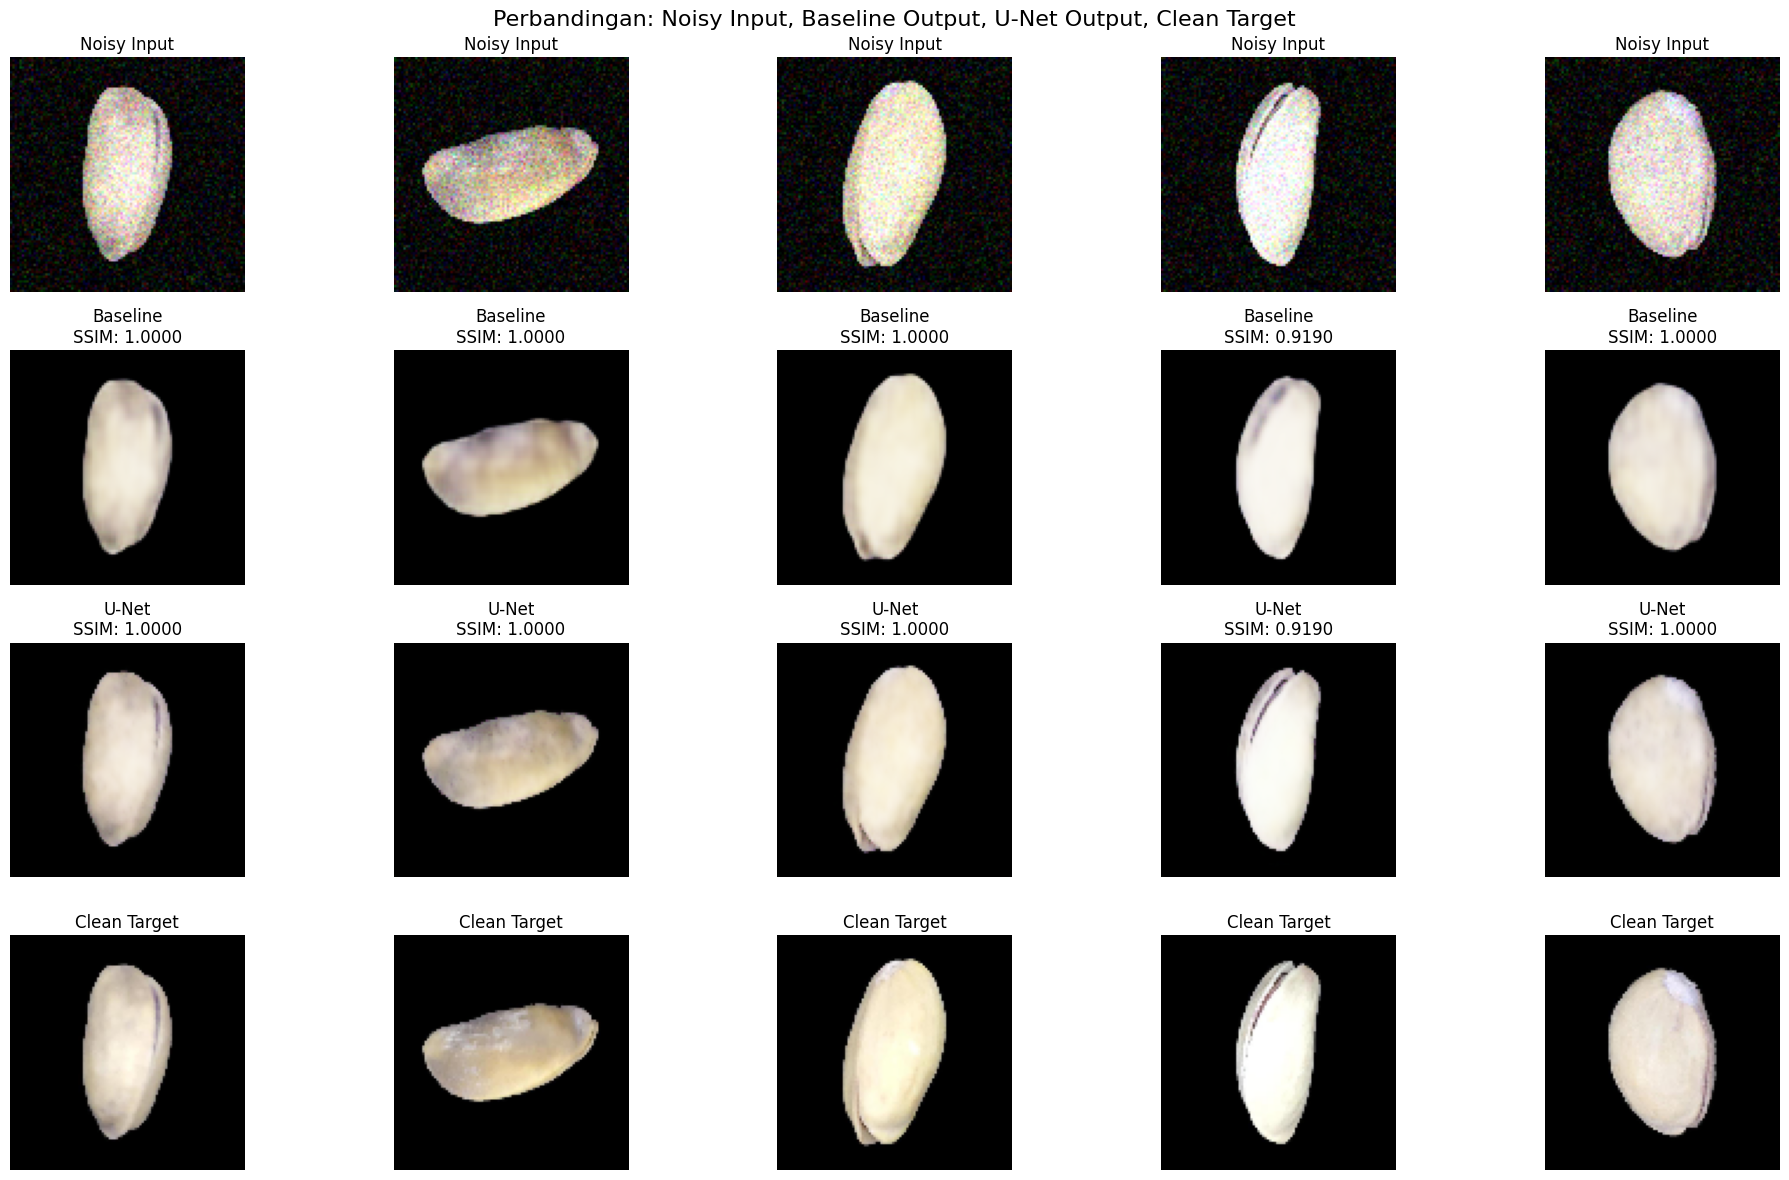

In [ ]:
print("\n\n--- Bagian e: Evaluasi Model Baseline dan U-Net ---")
print("Tujuan: Menghitung nilai SSIM dan menganalisa performa kedua model.")

if 'baseline_autoencoder' in locals() and 'unet_autoencoder' in locals() and \
   'X_test' in locals() and len(X_test) > 0:

    print("\nMelakukan prediksi dengan Model Baseline pada Testing Set...")
    decoded_images_baseline = baseline_autoencoder.predict(X_test)

    print("Melakukan prediksi dengan Model U-Net pada Testing Set...")
    decoded_images_unet = unet_autoencoder.predict(X_test)

     # Function untuk hitung rata-rata SSIM
    def calculate_mean_ssim(original_images, denoised_images):
        ssim_scores = []
        for i in range(len(original_images)):

            # Ubah ke uint8 biar bisa dihitung SSIM
            original_img_uint8 = (original_images[i] * 255).astype(np.uint8)
            denoised_img_uint8 = (denoised_images[i] * 255).astype(np.uint8)

            # Ubah ke grayscale (rata-rata kanal RGB)
            original_gray = np.mean(original_img_uint8, axis=2).astype(np.uint8)
            denoised_gray = np.mean(denoised_img_uint8, axis=2).astype(np.uint8)

             # Hitung SSIM per gambar
            score = ssim(original_gray, denoised_gray, data_range=255)
            ssim_scores.append(score)
        return np.mean(ssim_scores)

    # Hitung SSIM noise
    print("\nMenghitung SSIM (Noisy Input vs Clean Target) pada Testing Set...")
    mean_ssim_noisy_vs_clean = calculate_mean_ssim(y_test, X_test)
    print(f"Rata-rata SSIM (Noisy Input vs Clean Target): {mean_ssim_noisy_vs_clean:.4f}")

    # Hitung SSIM baseline
    print("Menghitung SSIM (Denoised Baseline vs Clean Target) pada Testing Set...")
    mean_ssim_baseline = calculate_mean_ssim(y_test, decoded_images_baseline)
    print(f"Rata-rata SSIM (Model Baseline vs Clean Target): {mean_ssim_baseline:.4f}")

     # Hitung SSIM U-Net
    print("Menghitung SSIM (Denoised U-Net vs Clean Target) pada Testing Set...")
    mean_ssim_unet = calculate_mean_ssim(y_test, decoded_images_unet)
    print(f"Rata-rata SSIM (Model U-Net vs Clean Target): {mean_ssim_unet:.4f}")

    # Analisis nilai SSIM
    print("\n--- Analisa Performa Model ---")
    print(f"SSIM Baseline (Noisy Input): {mean_ssim_noisy_vs_clean:.4f}")
    print(f"SSIM Model Baseline: {mean_ssim_baseline:.4f}")
    print(f"SSIM Model U-Net: {mean_ssim_unet:.4f}")

    print("\nAnalisa Kuantitatif (Berdasarkan Nilai SSIM):")
    if mean_ssim_baseline > mean_ssim_noisy_vs_clean:
        print("  - Model Baseline berhasil mengurangi noise.")
    else:
        print("  - Model Baseline kurang efektif dalam mengurangi noise.")

    if mean_ssim_unet > mean_ssim_noisy_vs_clean:
        print("  - Model U-Net berhasil mengurangi noise.")
        if mean_ssim_unet > mean_ssim_baseline:
            print("  - **U-Net LEBIH BAIK** dari Baseline dalam menghilangkan noise.")
        elif mean_ssim_unet < mean_ssim_baseline:
            print("  - **U-Net LEBIH BURUK** dari Baseline.")
        else:
            print("  - **U-Net SETARA** dengan Baseline.")
    else:
        print("  - Model U-Net tidak efektif dalam mengurangi noise.")

    # Visualisasi
    print("\nVisualisasi Contoh Denoising (Output dari Model):")
    n_display = min(5, len(X_test))
    plt.figure(figsize=(20, 12))

    for i in range(n_display):
        # Noisy
        ax = plt.subplot(4, n_display, i + 1)
        plt.imshow(X_test[i])
        plt.title("Noisy Input")
        plt.axis('off')

        # Baseline
        ax = plt.subplot(4, n_display, i + 1 + n_display)
        plt.imshow(decoded_images_baseline[i])
        ssim_val_baseline_sample = ssim(
            np.mean(y_test[i], axis=2).astype(np.uint8),
            np.mean(decoded_images_baseline[i], axis=2).astype(np.uint8),
            data_range=1.0
        )
        plt.title(f"Baseline\nSSIM: {ssim_val_baseline_sample:.4f}")
        plt.axis('off')

        # U-Net
        ax = plt.subplot(4, n_display, i + 1 + 2 * n_display)
        plt.imshow(decoded_images_unet[i])
        ssim_val_unet_sample = ssim(
            np.mean(y_test[i], axis=2).astype(np.uint8),
            np.mean(decoded_images_unet[i], axis=2).astype(np.uint8),
            data_range=1.0
        )
        plt.title(f"U-Net\nSSIM: {ssim_val_unet_sample:.4f}")
        plt.axis('off')

        # Clean Target
        ax = plt.subplot(4, n_display, i + 1 + 3 * n_display)
        plt.imshow(y_test[i])
        plt.title("Clean Target")
        plt.axis('off')

    plt.suptitle("Perbandingan: Noisy Input, Baseline Output, U-Net Output, Clean Target", fontsize=16)
    plt.tight_layout()
    plt.show()

else:
    print("\n[ERROR]: Tidak dapat melakukan evaluasi karena model atau data testing tidak siap.")

Berdasarkan hasil evaluasi menggunakan metrik SSIM, terlihat bahwa baik model Baseline maupun U-Net berhasil mengurangi noise dari gambar, dengan nilai SSIM yang jauh lebih tinggi dibanding input noisy. **Model Baseline** mencapai SSIM sebesar **0.9536**, sementara **U-Net** mencatat hasil yang lebih tinggi yaitu **0.9755**. **Menunjukkan bahwa U-Net tidak hanya efektif dalam denoising, tetapi juga memberikan hasil yang lebih baik dibanding model Baseline.**